## Imports and Cleaning

In [2]:
# CD over to local directory to access helper functions in the interactive notebook
!cd ~/Documents/Data_Projects/COVID/COVID-19

In [3]:
# Change default display options of pandas
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 150)

from datetime import timedelta
import math

# Use seaborn styling
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.rcParams['figure.dpi']= 600
sns.set()

# Interactive visualizations
import plotly
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go

# Pull auxillary functions for data processing
from data_clean import *
from viz_helper import *
%load_ext autoreload
%autoreload 10

### Live data
For this project, data is read in live from Johns Hopkins CSSE, the New York Times, and the Covid Tracking Project (associated with The Atlantic). The update times for each source differ across the sources, but are typically fully updated by the next day. 
Their sources, on the other hand, are from a collection of government agencies for international cases, and often state health department websites for county and state level information. The COVID Tracking Project provides a grade for each state depending on the reliability of testing data: https://covidtracking.com/about-data.
For quick dashboards, check out the Hopkins CSSE dash: https://coronavirus.jhu.edu/map.html.


In [4]:
# Countries from Johns Hopkins, State & Local from NYT, and Testing from the Covid Tracking Project
countries = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
states = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv')
local = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv')

In [5]:
df_country = clean_data_hopkins(countries, country='all')
df_state = clean_data_nyt(states, level='state')
df_local = clean_data_nyt(local, level='local')

/anaconda3/envs/covid/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning:

divide by zero encountered in log

/anaconda3/envs/covid/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning:

invalid value encountered in log



In [6]:
testing = pd.read_json('https://covidtracking.com/api/v1/states/daily.json')
df_testing = clean_data_trackingproject(testing)

In [7]:
# Quick list of dates when US states entered into some form of containment or lockdown
containment = pd.read_csv('containment.txt')
containment.columns = ['State', 'Date']
containment = containment.sort_values(by='Date').groupby(by='State').agg('last').reset_index()
containment.sample(3)

,State,Date
0,Alabama,2020-03-27
15,Kentucky,2020-03-27
12,Illinois,2020-03-22


In [8]:
# US population census data 
# us_census = pd.read_csv("../input/us-census-demographic-data/acs2017_county_data.csv")
# state_abbr = pd.read_csv("https://raw.githubusercontent.com/jasonong/List-of-US-States/master/states.csv")

In [9]:
df_country[df_country.Country.isin(['US'])].tail(3)

,Country,Date,Confirmed,EpidemicStartDate,DaysElapsed,NewConfirmed,DaysElapsed_Log,Confirmed_Log,NewConfirmed_Log
14416,US,2020-04-08,429052,2020-01-24,76,32829.0,4.330733,12.969333,10.399068
14601,US,2020-04-09,461437,2020-01-24,77,32385.0,4.343805,13.042101,10.385451
14786,US,2020-04-10,496535,2020-01-24,78,35098.0,4.356709,13.115409,10.465899


In [10]:
# NYT aggregated state counts differ somewhat from hopkins (Usually within 1% error)
pd.DataFrame(df_state.groupby('Date').sum().Confirmed - df_country[df_country.Country=='US'].groupby('Date').sum().Confirmed).dropna().tail(7)

,Confirmed
Date,
2020-04-03,915.0
2020-04-04,2683.0
2020-04-05,-298.0
2020-04-06,-429.0
2020-04-07,1531.0
2020-04-08,267.0
2020-04-09,2247.0


## Are we flattening the curve?

### New confirmed cases vs cumulatative cases

For an exponential growth function, the slope of the curve, or daily increase in cases should always remain proportional to the total number of cases in a given region. With that expectation, we would expect regions experiencing exponential growth to exhibit linearity when plotting log of new cases against log of current cases. Countries that have moved past this plateau, such as South Korea and China (as of 4/05), should taper off, as described in the following video by Henry Reich and Aashish B: https://www.youtube.com/watch?v=54XLXg4fYsc

Why does this work?
If a given infected individual passes on the virus to a rate of $k$ other people, we can model the rate of change of the number of infected as $dY/dt=kY$, where k is is that rate of transmission, and Y is the current number of infected individuals. By integrating this function, we get a simple exponential model in the form of $Y = Ae^{rt}$. 

As long as we operate under the assumption of exponential growth, we would expect that the slope of the curve is proportional to the current value of the curve at a point in time. In other words, we should expect that regardless of what exact time along the curve we're looking at (and thus what the current case count for that day is), the daily increase in case counts from the previous day (roughly the derivative in the discrete case) should be at the same proportion. When we plot that out here, using `NewConfirmed` and `Confirmed` counts for various countries, we can see that countries who have plateaued start to fall off that line quite rapidly. This makes it an incredibly powerful and visual tool to see where we are in the long-term trajectory. 

<!-- However, a virus can't simply be growing exponentially for perpetuity, as we'll eventually hit some upper ceiling, which is quite literally just the number of people in the population. We can then adjust our previous model by adding in a factor for how far we are away from that limit, or $Y/L$, where L is the population limit: $dy/dt = kY(1-Y/L)$. This corresponds to our logistic curve. Note that when $Y$ is much smaller than $L$, the ratio of $Y/L$ goes to zero, and the rate of change looks a lot like the exponential.  -->

In [16]:
countriesToPlot = ['US', 'Korea, South', 'Italy', 'China']
fig =   px.scatter(data_frame=df_country[df_country.Country.isin(countriesToPlot)].loc[df_country.Confirmed > 50], 
                   x='Confirmed', y='NewConfirmed', color='Country', symbol='Country', opacity=0.9,
                   log_x=True,log_y=True, 
                   hover_name='Date', hover_data=['NewConfirmed','Confirmed','Date','EpidemicStartDate'],
                   title='New Confirmed Cases vs Cumulative Cases Per Day (Logged, International)', template='ggplot2', 
                   color_discrete_sequence= px.colors.qualitative.T10, 
                  )
fig.show(width=1000, height=600,
#          renderer='svg', # Leave this commented out for an interactive plot
        )

From this plot, it appears that China and South Korea have defintely been able to plateau out, while Italy is nearing the end of the tunnel. (04/10/20)

In [12]:
# To Do: Animated scatter against date

Applying the same visualizations onto select US states:

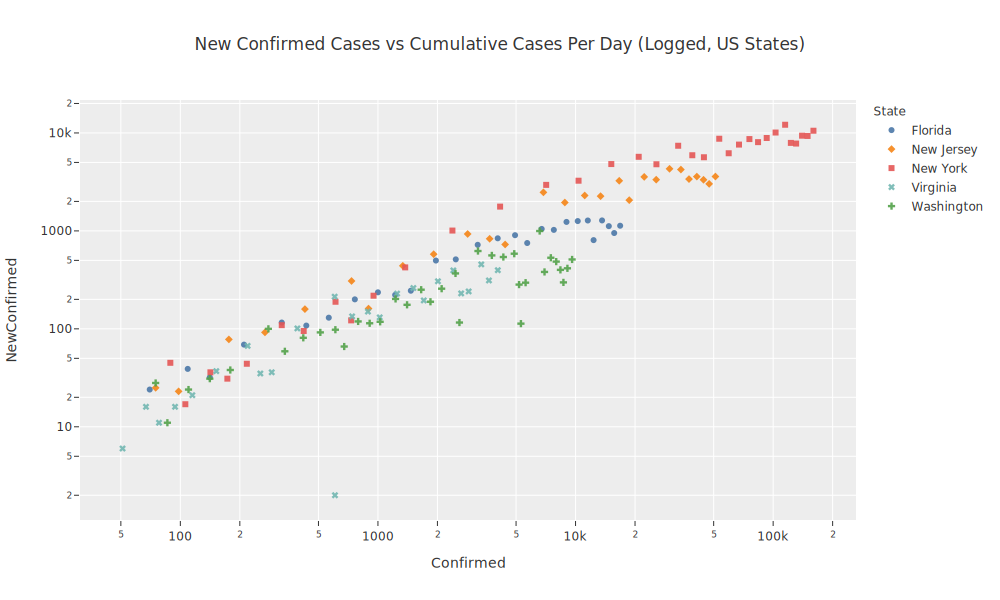

In [20]:
statesToPlot = ['New York', 'New Jersey', 'Washington', 'Lousiana', 'Virginia', 'Florida']
fig =   px.scatter(data_frame=df_state[df_state.State.isin(statesToPlot)].loc[df_state.Confirmed>50], 
                   x='Confirmed', y='NewConfirmed', color='State', symbol='State',
                   log_x=True,log_y=True, labels={'y':'Daily New Cases', 'x':'Cumulative Confirmed Cases'},
                   hover_name='Date', hover_data=['State','DaysElapsed','Date','EpidemicStartDate'],
                   title='New Confirmed Cases vs Cumulative Cases Per Day (Logged, US States)', template='ggplot2', 
                   color_discrete_sequence= px.colors.qualitative.T10, opacity=0.9
#                    color_continuous_scale='Teal_r', 
                  )
# Add smoothed lines
fig.update(layout_coloraxis_showscale=False)
fig.show(width=1000, height=600,
         renderer='svg'
        )

## Some time series plots

### Confirmed cases in US States with governor lockdown measures 
Containment is a critical measure in reducing effective reproductive number of the virus. Most early-stage growth models can be viewed as a piecewise composition of a basic reproduction number ($R_0$) and a second effective reproduction number($R_e$). A team at the University of Toronto has a great article and corresponding dashboard explaining this concept: https://annals.org/aim/fullarticle/2760912/reporting-epidemic-growth-reproduction-numbers-2019-novel-coronavirus-2019-ncov. 

US states have undergone containment measures along different timelines. Assuming a delay comprised of a biological incubation, delay for testing & recording, we can expect to see tangible changes to ($R_e$) roughly 1.5 - 2 weeks following an intervention. However, the gradual change in rate, as opposed to a piecewise shift we'd expect following the containment reflects the fact that lockdowns in the US have not been as stringent as in China, for example, and may only slow the growth, instead of dropping the rate down below 1.

New Jersey entered containment on 2020-03-22
New York entered containment on 2020-03-23
Virginia entered containment on 2020-03-30
Washington entered containment on 2020-03-23


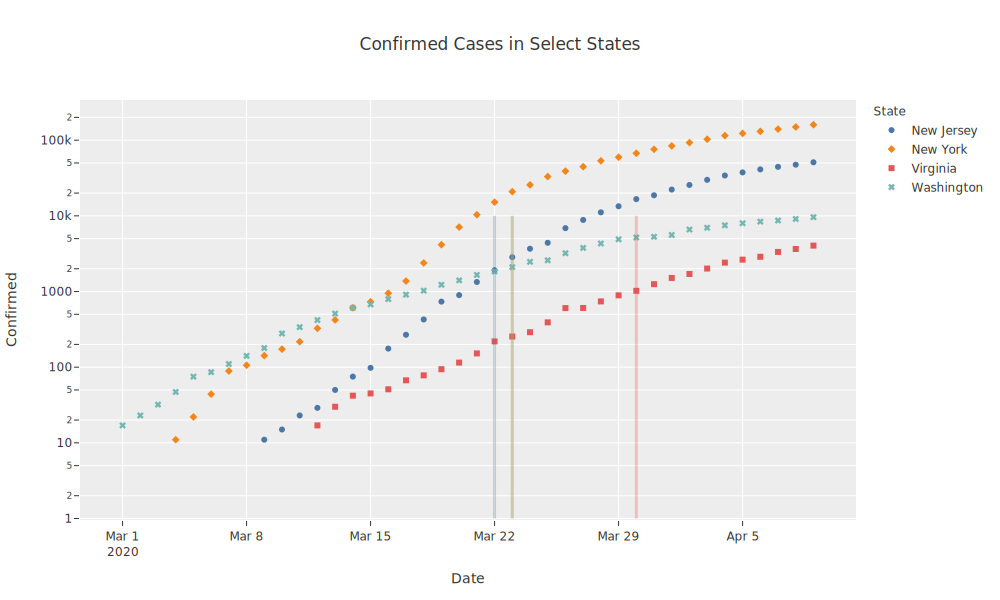

In [25]:
states = ['New York', 'New Jersey', 'Washington', 'Virginia']
fig =px.scatter(data_frame=df_state[df_state.State.isin(states)].loc[df_state.Confirmed > 10], 
                x='Date', y='Confirmed', color='State', symbol='State',
                log_x=False,log_y=True, labels={'y':'Daily New Cases', 'x':'Cumulative Confirmed Cases'},
                hover_name='Date', hover_data=['NewConfirmed','Confirmed','DaysElapsed'],
                title='Confirmed Cases in Select States', template='ggplot2', 
                color_discrete_sequence=px.colors.qualitative.T10,
               )

c = 0
for s in sorted(states):
    containment_date = containment[containment.State==s].Date.values[0]
    fig.add_shape(dict(type="line", 
                       x0=containment_date, y0=1, x1=containment_date, y1=10000, 
                       line=dict(color=px.colors.qualitative.T10[c],
                                 width=3, dash='solid'
                                )))
    c += 1
    print('{} entered containment on {}'.format(s, containment_date))
    
fig.update_shapes(dict(xref='x', yref='y'))

fig.show(width=1000, height=600,
         renderer='svg'
        )

## Testing, testing, testing 

### Tests vs. Cases
As seen in the Wall Street Journal: https://www.wsj.com/articles/how-the-cdcs-restrictive-testing-guidelines-hid-the-coronavirus-epidemic-11584882001.
The biggest issue with any modelling is reliabilty of data. Without comprehensive data on the number of infected, recovered, and susceptible individuals in a community, it becomes incredibly hard for policy makers to make decisions to reopen parts of the economy confidently. 

(As per my knowledge) These tests are almost all RT-PCR tests, which test for viral nucleic acid (the instructions needed to replicate). An actively infected (or exposed) individual will have this in their body fluids, but those who have been exposed and successfully recovered (that is, they've developed antibodies to excise the virus from their system), will no longer have these strands of RNA and subsequently test negative. (That's where serological tests come in, but that's another issue).

As availability of testing kits have been rather scarce, one way to better estimate the number of infected patients in a commmunity may be to look at the proportion of tests administered that come up positive. The higher the ratio, the greater one could "weight" the confirmed case counts from that day– if almost every test administered comes back positive, it means that there's probably a lot of folks who haven't gotten tested yet and defintely should. 

In [37]:
df_testing.sort_values(by='Date').groupby(['State']).agg('last').reset_index().sample(3)

,State,Date,Positive,Negative,Pending,HospitalizedCurrently,HospitalizedCumulative,InIcuCurrently,InIcuCumulative,OnVentilatorCurrently,OnVentilatorCumulative,Recovered,Death,Hospitalized,Total,TotalTestResults,PosNeg,DeathIncrease,HospitalizedIncrease,NegativeIncrease,PositiveIncrease,TotalTestResultsIncrease
39,OK,2020-04-09,1684.0,18595.0,102.0,188.0,415.0,120.0,NaN,NaN,NaN,686.0,80.0,415.0,20279,20279,20279,1.0,25.0,6774.0,160.0,6934.0
0,AK,2020-04-09,235.0,6988.0,13.0,NaN,27.0,NaN,NaN,NaN,NaN,49.0,7.0,27.0,7223,7223,7223,0.0,0.0,146.0,9.0,155.0
37,NY,2020-04-09,159937.0,231612.0,236.0,18279.0,32869.0,4925.0,NaN,NaN,NaN,14590.0,7067.0,32869.0,391549,391549,391549,799.0,200.0,15775.0,10621.0,26396.0


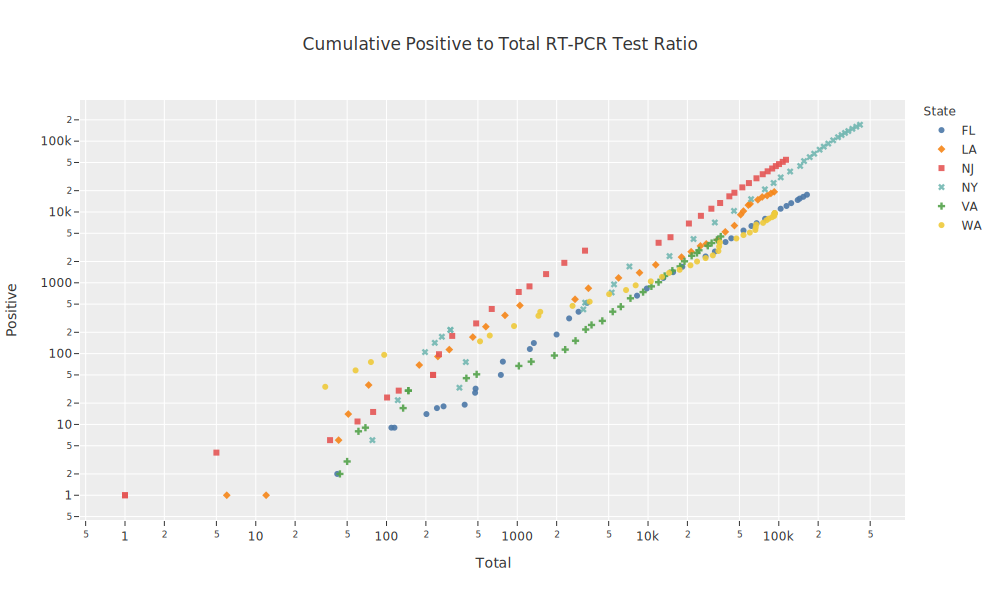

In [32]:
states = ['NY', 'NJ', 'WA', 'VA', 'FL', 'LA']
fig = px.scatter(data_frame=df_testing.loc[df_testing.State.isin(states)].loc[df_testing.Date > pd.to_datetime('2020-03-01')],
                 x='Total', y='Positive', color='State', symbol='State', opacity=.9, 
                 color_discrete_sequence=px.colors.qualitative.T10,
                 log_x=True, log_y=True, 
                 title='Cumulative Positive to Total RT-PCR Test Ratio',
                 hover_name='Date', hover_data=['Positive','Total', 'Negative', 'State'],
                 template='ggplot2', 
                )
fig.show(width=1000, height=600,
         renderer='svg', # Leave this commented out for an interactive plot
        )

We could also look at the first difference of the cumulative positive and total test data (think derivative, but instead of $dy/dt$, we've got $y_t - y_{t-1}$. This may be a lot more sensitive to noise at the lower value counts, but can still be helpful in showing how the positive detection for a state has changed over time.

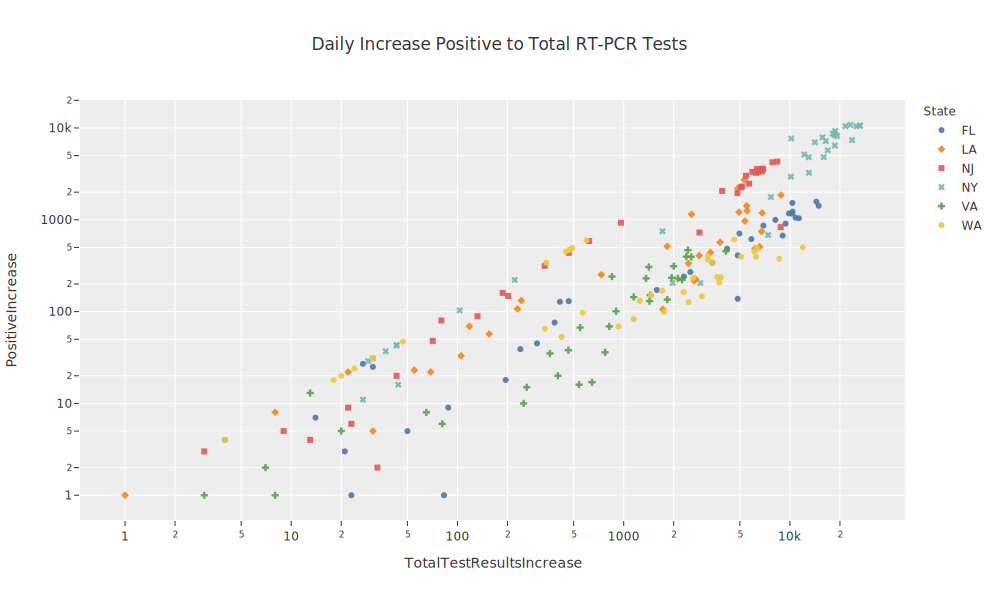

In [36]:
states = ['NY', 'NJ', 'WA', 'VA', 'FL', 'LA']
fig = px.scatter(data_frame=df_testing.loc[df_testing.State.isin(states)].loc[df_testing.Date > pd.to_datetime('2020-03-01')],
                 x='TotalTestResultsIncrease', y='PositiveIncrease', color='State', symbol='State', opacity=.9, 
                 color_discrete_sequence=px.colors.qualitative.T10,
                 log_x=True, log_y=True, 
                 title='Daily Increase Positive to Total RT-PCR Tests',
                 hover_name='Date', hover_data=['Positive','Total', 'Negative', 'State'],
                 template='ggplot2', 
                )
fig.show(width=1000, height=600,
         renderer='svg', # Leave this commented out for an interactive plot
        )

In [41]:
# fig = px.scatter(data_frame=df_testing.sort_values(by='Date').groupby(['State']).agg('last').reset_index(),
#                  x='Positive', y='Total', color='State', 
#                  log_x=False, log_y=False, template='ggplot2',
#                 )
# fig.show()

# ## Animate this over time

## Hospitalizations & Burden on Healthcare

In [42]:
"""
# Adapted from https://www.kaggle.com/hrmello/us-health-care-system-dive-into-ny
icu_facilities = pd.read_csv("/kaggle/input/uncover/hifld/hifld/urgent-care-facilities.csv")
us_census = pd.read_csv("../input/us-census-demographic-data/acs2017_county_data.csv")
state_abbr = pd.read_csv("https://raw.githubusercontent.com/jasonong/List-of-US-States/master/states.csv")


icus_per_state = pd.DataFrame(icu_facilities.groupby(["state"])["id"].nunique()).reset_index()

us_census = us_census.merge(states_abbr, on = "State")
us_census = us_census.rename(columns = {"State": "fullState", "Abbreviation": "state"})

popState = us_census.groupby("state")["TotalPop"].sum().reset_index()

icupopdf = icus_per_state.merge(popState, on = "state")
icupopdf["ICUPopRatio"] = icupopdf["id"]/icupopdf["TotalPop"] * 100000
"""

'\n# Adapted from https://www.kaggle.com/hrmello/us-health-care-system-dive-into-ny\nicu_facilities = pd.read_csv("/kaggle/input/uncover/hifld/hifld/urgent-care-facilities.csv")\nus_census = pd.read_csv("../input/us-census-demographic-data/acs2017_county_data.csv")\nstate_abbr = pd.read_csv("https://raw.githubusercontent.com/jasonong/List-of-US-States/master/states.csv")\n\n\nicus_per_state = pd.DataFrame(icu_facilities.groupby(["state"])["id"].nunique()).reset_index()\n\nus_census = us_census.merge(states_abbr, on = "State")\nus_census = us_census.rename(columns = {"State": "fullState", "Abbreviation": "state"})\n\npopState = us_census.groupby("state")["TotalPop"].sum().reset_index()\n\nicupopdf = icus_per_state.merge(popState, on = "state")\nicupopdf["ICUPopRatio"] = icupopdf["id"]/icupopdf["TotalPop"] * 100000\n'

## Geographic distribution of cases

In [21]:
# px.choropleth(data_frame=df_country[df_country.Country.isin(['US', 'Korea, South', 'Italy'])],
#               lat='Lat', lon='Long',
#              )